# Approximation Algorithms for Vertex Cover


In this note, we revisit the vertex cover problem which has been introduced previously. Our goal is to examine two greedy algorithms: one that will strike most students as natural, when faced with the vertex cover problem, and one that on first glance does not seem such a good idea but can provide much better approximation guarantees.

<div class="alert alert-block alert-success">
    <b>Credit:</b> I must acknowledge  Prof. Jeff Erickson's exposition on this topic. It has served as a great source for my notes which will add a few more details including some visualizations in Python -- <a href="https://jeffe.cs.illinois.edu/teaching/algorithms/notes/J-approx.pdf"> Click here </a> 
</div>

## Vertex Cover Problem

Consider an undirected graph $G$ with vertices $V = \{ 1, \ldots, n \}$ and undirected edges $E$. Since the graph is undirected, we  consider edges $(i,j)$ and $(j,i)$ to be the _same_.

<div class="alert alert-block alert-info">
    <b> Vertex Cover: </b> A <i> vertex cover </i> of the graph is a subset $C \subseteq V$ such that every edge $e \in V$ has at least one of its end points in the set $C$.
    </div> 

Note that the entire vertex set $V$ is trivially a vertex cover. The vertex cover problem asks for the smallest size (cardinality) vertex cover for a given undirected graph $G$. 

### Example

<div class="alert alert-block alert-info">
Suppose a graph $G$ has nodes that represent people and edges between people denote the fact that they are <i> facebook friends</i>. Suppose you are an advertiser who wishes to advertise but sending an advertisement to each person costs you money. When you advertise to someone your ad will show up in their friend's facebook timeline. What is the minimum number of people you need to advertise so that your ad will show up on everyone's timeline? The answer is a minimum vertex cover of the graph $G$.
</div>

We have seen previously that the problem is NP-complete and can be solved in many ways including a reduction to integer linear programming. 

Here, we consider fast algorithms for computing an approximate vertex cover and our natural choice is to consider greedy algorithms.


## Example

<div class="alert alert-block" style="border-style: solid; border-width: 2px; border-color: white  white white green;" >
    
Consider the example below where we show a graph with five nodes and the nodes in the vertex cover shaded in orange. In fact, the set $\{ 1, 4, 5\}$ is a vertex cover but there is in fact a smaller vertex cover consisting just the nodes $\{4, 5\}$.

</div>

In [1]:
import networkx as nx
from matplotlib import pyplot as plt
from pylab import rcParams

# Use matplotlib and networkx to plot graphs with a designated
# vertex cover passed in as a list of vertices.
# n: number of vertices
# edge_list: list of edges. please ensure that if edge (i,j) 
#            is present then (j,i) is not. We will not be checking this.
# vert_cover: list of vertices in the cover to highlight in orange.
# All nodes will be plotted in blue with vertex cover highlighted in orange.
def plot_graph_with_vc(n, edge_list, vert_cover):
    g = nx.Graph()
    g.add_edges_from(edge_list)
    pos = nx.spring_layout(g)  # positions for all nodes
    not_vert_cover = [i for i in range(1, n+1) if i not in vert_cover]
    plt.figure(1)
    nx.draw_networkx_nodes(g, pos, nodelist=vert_cover,  node_color="tab:orange")
    nx.draw_networkx_nodes(g, pos, nodelist=not_vert_cover,  node_color="tab:blue")
    nx.draw_networkx_edges(g, pos, edgelist=edge_list)
    nx.draw_networkx_labels(g, pos, font_size=12, font_color="whitesmoke")
    plt.show()
    

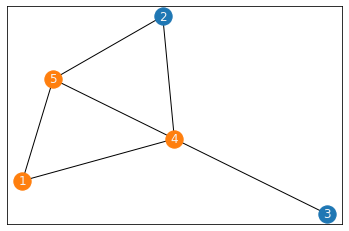

In [2]:
edge_list=[ (1,4), (1,5), (2,5), (2,4), (3,4), (4,5)]
vert_cover = [1,  4, 5]
plot_graph_with_vc(5, edge_list, vert_cover)

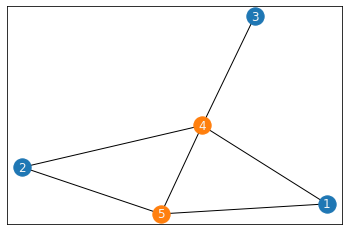

In [3]:
edge_list=[ (1,4), (1,5), (2,5), (2,4), (3,4), (4,5)]
smaller_vert_cover = [4, 5]
plot_graph_with_vc(5, edge_list, smaller_vert_cover)

In [4]:
from pulp import * 

def compute_optimal_vertex_cover(n, edge_list):
    prob = LpProblem('vert_cover', LpMinimize)
    dvars = [LpVariable(f'w_{i}', cat='Binary') for i in range(1, n+1)]
    prob += lpSum(dvars) # minimuze the sum of the variables
    for (i, j) in edge_list:
        assert 1 <= i <= n 
        assert 1 <= j <= n
        prob += dvars[i-1] + dvars[j-1] >= 1 # wi + wj >= 1
    stat = prob.solve()
    assert stat == LpStatusOptimal
    vert_cover = [i+1 for i in range(n) if dvars[i].varValue > 0 ]
    return vert_cover

## Greedy Algorithm for Vertex Cover.


First recall that the degree of a node is simply the number of edges that are incident on it.
Let's start with a simple greedy algorithm:

<div class="alert alert-block alert-info">
    <b> Greedy Algorithm for Vertex Cover: </b>
<br> 1. While there are edges left in the graph:
<br> &nbsp; &nbsp;&nbsp;&nbsp;&nbsp;    1.1 Choose the node i with largest degree (break ties arbitrarily).
<br> &nbsp; &nbsp;&nbsp;&nbsp;&nbsp;     1.2 Add node i to the vertex cover 
<br> &nbsp; &nbsp;&nbsp;&nbsp;&nbsp;     1.3 Delete all incident edges on node $i$.
<br>
</div>

<div style="border-style: solid; border-width: 2px; border-color: white  white white green;" >
For the example above, the greedy algorithm performs as follows:
  <p> <br> 1. Vertex $4$ has degree $4$ and is the highest. 
  <br> 2. Choose this vertex as part of the vertex cover.
  <br> 3. Remove  all its incident edges.
  <br> 4. Among the remaining vertices (after edges have been deleted), vertex $5$ has the highest degree. 
  <br> 5. Add vertex $5$ to the cover, delete  all its incident edges.
  <br> 6. No more edges are left.
  <br> 7. The greedy algorithm returns the cover $\{ 4, 5\}$ which is actually optimal!
</div>

In [5]:

def greedy_vertex_cover(n, orig_edge_list): 
    edge_list = [(i,j) if i < j else (j,i) for (i,j) in orig_edge_list]
    # Construct an adjacency list representation -- for every vertex collect all incident edges.
    adj_list = [set() for i in range(n+1)]
    for (i, j) in edge_list:
        adj_list[i].add(j)
        adj_list[j].add(i)
    # store an array of degrees with the vertex id
    # negate the adjacency degree to get a maxheap
    degrees_with_vert_id = [(-float('inf'),0)] + [(len(adj_list[i]), i) for i in range(1,n+1)]
    num_edges_remaining = len(edge_list)
    # vertex cover list
    vert_cover = []
    while num_edges_remaining >= 1:
        max_degree_vert, vert_id = max(degrees_with_vert_id) # this would be faster if we used a priority queue
        print(f'Adding vertex: {vert_id} of degree {max_degree_vert} to the cover')
        vert_cover.append(vert_id)
        # now delete the edges incident on this vertex and update the degrees
        for j in adj_list[vert_id]: # iterate through all incident edges
            # remove all edges adjacent to vertex vert_id
            adj_list[j].remove(vert_id)
            num_edges_remaining -= 1
            # adjust the degrees
            (dj,_) = degrees_with_vert_id[j]
            degrees_with_vert_id[j] = (dj-1, j)
        degrees_with_vert_id[vert_id] = (0, vert_id)
        adj_list[vert_id] = set() 
    print('All edges removed')
    return vert_cover
  

In [6]:
from matplotlib.animation import FuncAnimation 
from IPython.display import HTML     
def animate_algorithm_result(n, edge_list, vert_cover,ax):
    g = nx.Graph()
    g.add_edges_from(edge_list)
    pos = nx.spring_layout(g)  # positions for all nodes
    def update(i):
        ax.clear()
        vertices_in_cover = vert_cover[:i]
        edges_covered = [(i,j) for (i,j) in edge_list if i in vertices_in_cover or j in vertices_in_cover]
        vertices_not_in_cover = [i for i in range(1,n+1) if i not in vertices_in_cover]
        edges_not_yet_covered = [(i,j) for (i,j) in edge_list if i not in vertices_in_cover and j not in vertices_in_cover]
        nx.draw_networkx_nodes(g, pos, ax = ax, nodelist=vertices_in_cover, node_size=1000, node_color="tab:orange")
        nx.draw_networkx_nodes(g, pos, ax = ax, nodelist=vertices_not_in_cover, node_size=800, node_color="tab:blue")
        nx.draw_networkx_edges(g, pos, ax = ax, edgelist=edges_covered, edge_color="gray", style="dashed")
        nx.draw_networkx_edges(g, pos, ax = ax, edgelist=edges_not_yet_covered, edge_color="black")
        nx.draw_networkx_labels(g, pos, ax = ax, font_size=12, font_color="whitesmoke")
    ani = FuncAnimation(fig, update, frames=len(vert_cover)+1)
    return HTML(ani.to_jshtml())
    

In [7]:
%matplotlib inline
edge_list=[ (1,4), (1,5), (2,5), (2,4), (3,4), (4,5)]
vcover = greedy_vertex_cover(5, edge_list)
#plot_graph_with_vc(5, edge_list, vcover)
fig, ax = plt.subplots(figsize=(6,4))
anim = animate_algorithm_result(5, edge_list, vcover, ax)
plt.close()
anim



Adding vertex: 4 of degree 4 to the cover
Adding vertex: 5 of degree 2 to the cover
All edges removed


Let's compare it with the optimal vertex cover. 

In [8]:
opt_vcover = compute_optimal_vertex_cover(5, edge_list)
print(opt_vcover)
print(f'Optimal vertex cover has {len(opt_vcover)} vertices')

[4, 5]
Optimal vertex cover has 2 vertices


### Example 2

In [9]:
edge_list=[ (1,4), (1,5), (2,5), (2,4), (3,4), (4,5),(1,8),(2,7), (7,8),(4,6), (5,7), (6,8), (3,1)]
vcover = greedy_vertex_cover(8, edge_list)
#plot_graph_with_vc(8, edge_list, vcover)
fig, ax = plt.subplots(figsize=(6,4))
anim = animate_algorithm_result(8, edge_list, vcover, ax)
plt.close()
anim

Adding vertex: 4 of degree 5 to the cover
Adding vertex: 8 of degree 3 to the cover
Adding vertex: 5 of degree 3 to the cover
Adding vertex: 7 of degree 1 to the cover
Adding vertex: 3 of degree 1 to the cover
All edges removed


Let's compare with the optimal vertex cover

[3, 4, 5, 7, 8]
Optimal vertex cover has 5 vertices


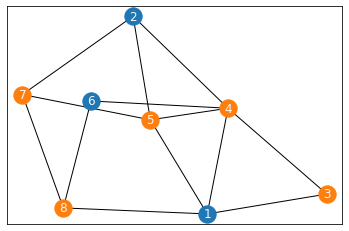

In [10]:
opt_vcover = compute_optimal_vertex_cover(8, edge_list)
print(opt_vcover)
print(f'Optimal vertex cover has {len(opt_vcover)} vertices')
plot_graph_with_vc(8, edge_list, opt_vcover)

### Example 3: Randomly generated graph

Adding vertex: 13 of degree 11 to the cover
Adding vertex: 11 of degree 10 to the cover
Adding vertex: 5 of degree 10 to the cover
Adding vertex: 17 of degree 8 to the cover
Adding vertex: 16 of degree 8 to the cover
Adding vertex: 9 of degree 7 to the cover
Adding vertex: 4 of degree 7 to the cover
Adding vertex: 1 of degree 6 to the cover
Adding vertex: 7 of degree 5 to the cover
Adding vertex: 21 of degree 4 to the cover
Adding vertex: 22 of degree 3 to the cover
Adding vertex: 14 of degree 3 to the cover
Adding vertex: 8 of degree 3 to the cover
Adding vertex: 24 of degree 2 to the cover
Adding vertex: 25 of degree 1 to the cover
Adding vertex: 23 of degree 1 to the cover
Adding vertex: 10 of degree 1 to the cover
All edges removed
Size of cover: 17


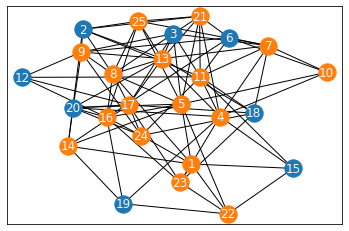

In [11]:
from random import randint
n = 25
edge_list = [ ]
for _ in range(120):
    i = randint(1, n)
    j = randint(1, n)
    if i == 0 or j == 0 or i == j or (i,j) in edge_list or (j,i) in edge_list: 
        continue
    edge_list.append((i,j))

vcover = greedy_vertex_cover(n, edge_list)
print(f'Size of cover: {len(vcover)}')
plot_graph_with_vc(n, edge_list, vcover)


[1, 2, 5, 7, 8, 9, 10, 11, 13, 15, 16, 17, 18, 19, 20, 21, 23]
Optimal vertex cover has 17 vertices


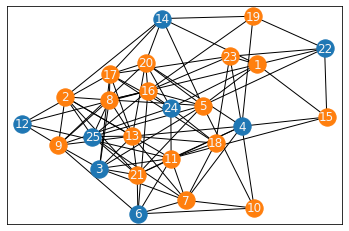

In [12]:
opt_vcover = compute_optimal_vertex_cover(n, edge_list)
print(opt_vcover)
print(f'Optimal vertex cover has {len(opt_vcover)} vertices')
plot_graph_with_vc(n, edge_list, opt_vcover)

## Analysis of Greedy Vertex Cover

So how does the greedy algorithm we have presented, thus far, perform in terms of the optimal vertex cover? We tried three examples and noticed that in two out of three, the greedy algorithm matched the optimal size vertex cover and in one of the graphs, it was quite close. Therefore, we expect the greedy algorithm to have performance _very close_ to that of the optimal cover, right?


### Worst Case

In the worst case, the greedy algorithm's performance can be as far away as $\alpha \log(n)$ times that of the optimal, where $n$ is the number of nodes in the graph and $\alpha$ is some constant that we will not worry about too much.

To show this, we construct a family of examples $G_2, G_3, \ldots, $ of increasing size where for each example $G_k$, the greedy algorithm will find a vertex cover of size roughly $k \log(k)$ while the optimal cover will be of size $k$. 

The back-bone of the construction is a set of vertices that we will label
$$ a_1, \ldots, a_n$$ 
Secretly the vertex cover will consist simply of these vertices.

To _confuse_ the greedy algorithm, we are going to add a sets of vertices, as follows.

- We start with $n$ vertices $ b_1^{(1)}, \ldots, b_1^{(n)}$, where each $b_1^{(i)}$ connects just to the vertex $a_i$.
- Next we will add $\lfloor n/2 \rfloor $ vertices  $b_2^{(1)}, b_2^{(2)}, \ldots, b_2^{(\lfloor n/2 \rfloor)}$ wherein $b_2^{(1)}$ connects to 
$a_1, a_2$, $b_2^{(2)}$ to $a_3, a_4$ and so on. In other words, $b_2^{(i)}$ connects to $a_{2i-1}$ and $a_{2i}$.  If $n$ is not divisible by $2$, then note that $a_{n}$ will not be connected to a vertex of the form $b_2^{(*)}$.
- We will add $\lfloor n/3\rfloor $ vertices $b_3^{(1)}, \ldots, b_3^{(n/3)}$ each connecting to three consecutive vertices : $b_3^{(1)}$ to $a_1, a_2, a_3$,  and in general, $b_3^{(i)}$ will connect to $a_{3i-2}, a_{3i-1}$ and $a_{3i}$. 
- We add vertices $b_j^{(1)}, \ldots, b_j^{(\lfloor n/j \rfloor)}$ where, each vertex $b_j^{(i)}$ connects to $j$
vertices $a_{ij-j+1}, \ldots, a_{ij}$.
- Finally, we will just have a single vertex $b_n^{(1)}$ that connects to all of $a_1, \ldots, a_n$.

Here is a picture of what the graph looks like with various nodes labeled:


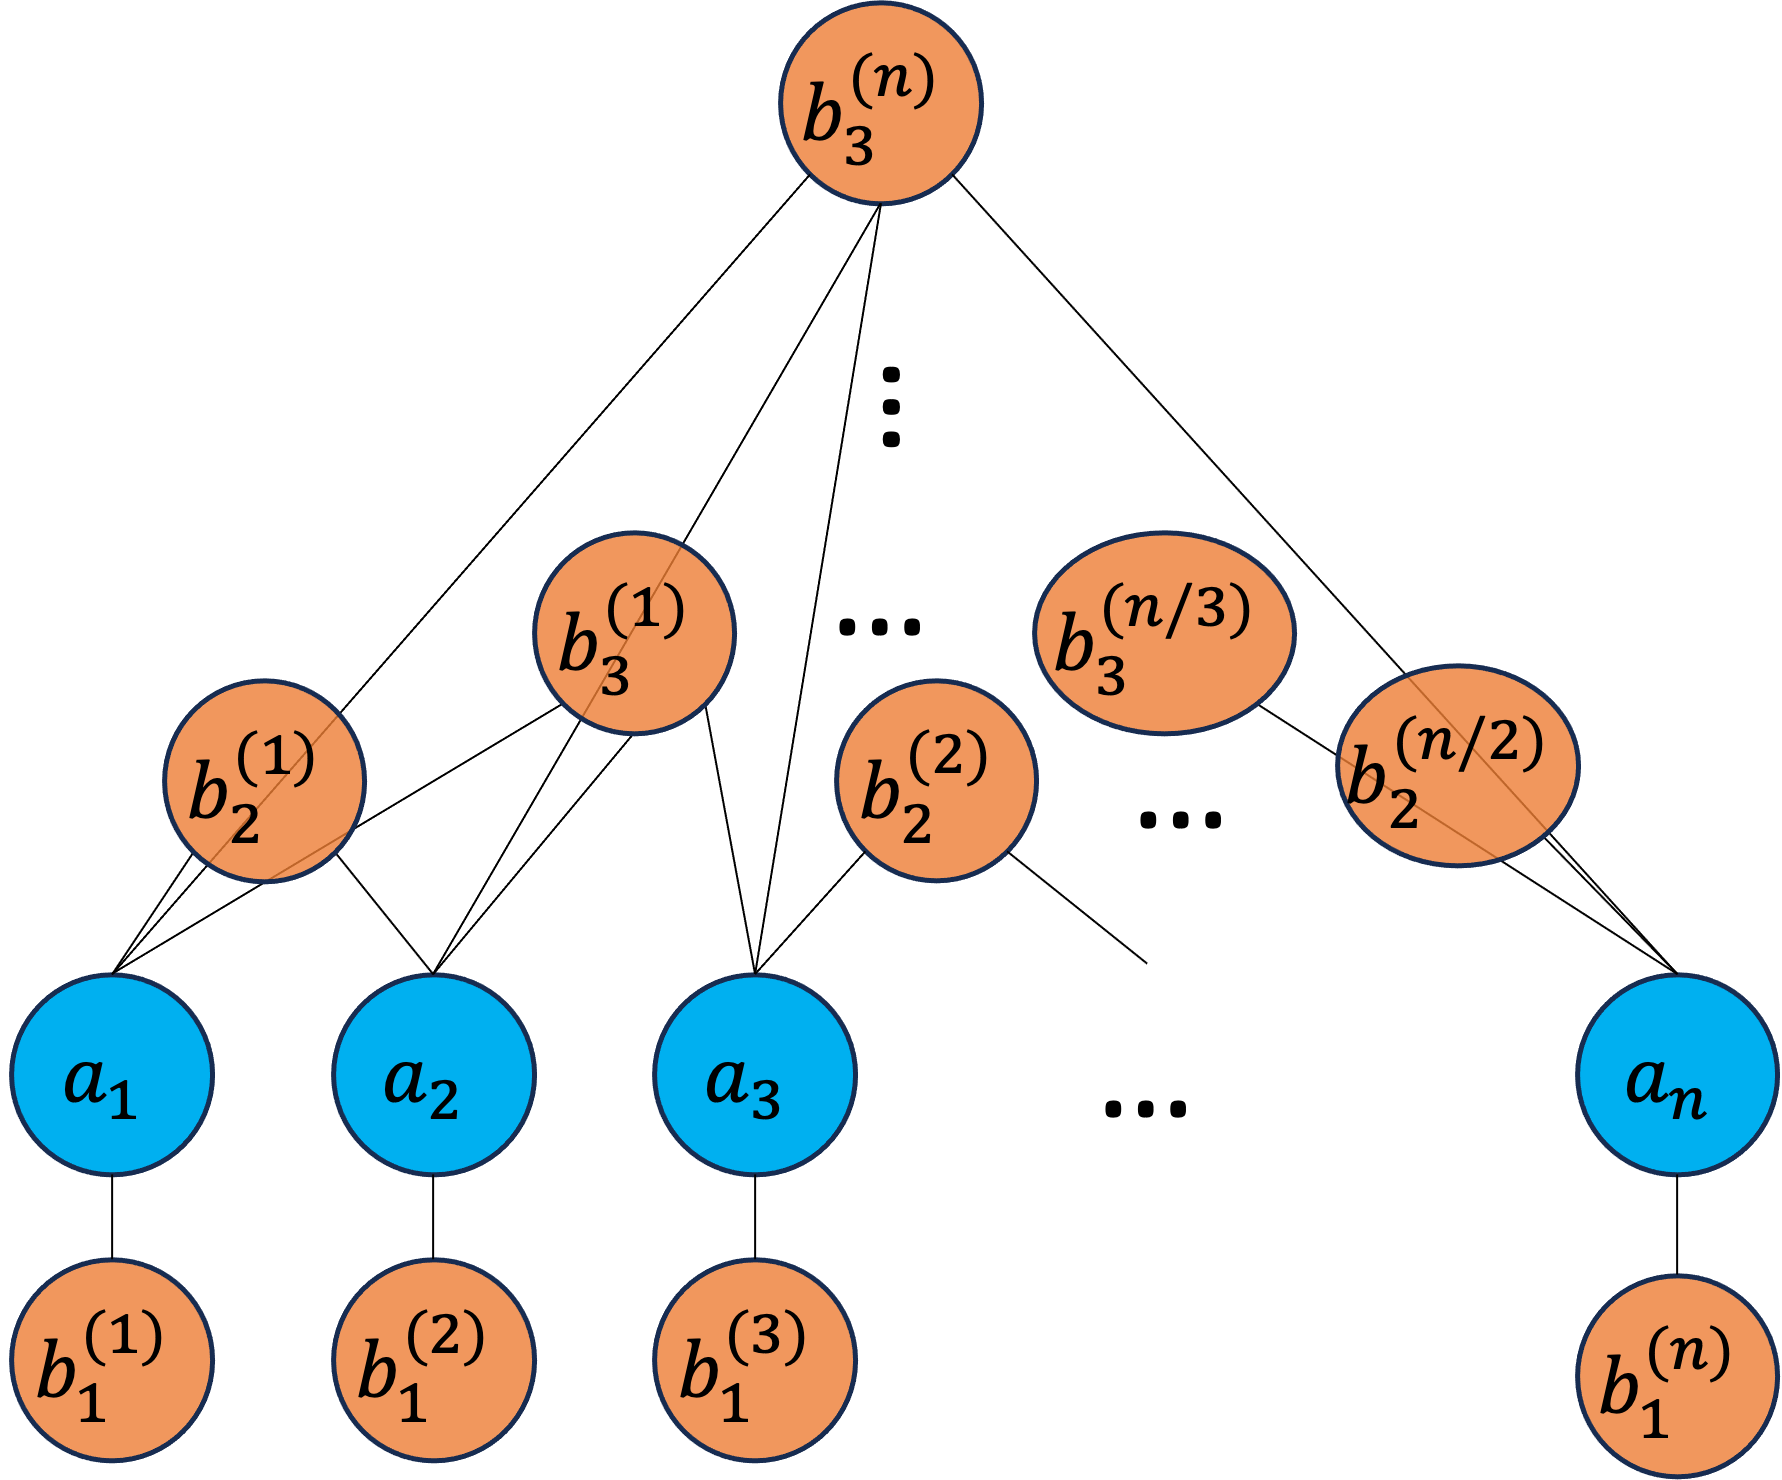 </img>


Some facts about the construction that you can check.
  - Every edge is between a node of the form $b_j^{(i)}$ to a node $a_i$. 
  - Each $a_i$ node has degree $\leq n$.
  - Each $b_i^{(j)}$ node has degree exactly $i$.
  - The set $\{ a_1, \ldots, a_n \}$ is the optimal vertex cover for this graph of size $n$.
  
We assume that whenever the greedy algorithm finds two nodes to have the same degree, it preferentially adds a $b_i^{(j)}$ type node to the cover.

The greedy algorithm proceeds to add each $b_i^{(j)}$ node to the cover one by one starting with $b_n^{(1)}$, and moving on down to $b_1^{(n)}$ until no more edges remain.

Therefore, the number of nodes added by greedy algorithm is given by 

$$ n + \lfloor n/2 \rfloor + \lfloor n/3 \rfloor + \cdots + 1 $$

We can check that this is $\Omega( n \log(n))$. However, the optimal cover as mentioned above is $a_1, \ldots, a_n$. Therefore, the greedy cover exceeds the optimal cover by a factor $\Omega(\log(n))$.

Here is a function that constructs the graph as described above.


In [13]:
def make_bad_example_for_greedy(n):
    num_vertices = n # start with n vertices 
    edge_list = [] # empty list of edges
    vert_labels = [f'a_{i}' for  i in range(1, n+1)] # we will name the vertices a_1, ..., a_n so far
    for i in range(1, n+1): # run through i from 1 to n inclusive
        j_lim = n//i # compute floor(n/i)
        cur_vert = 1
        for j in range(1, j_lim+1):
            num_vertices = num_vertices + 1
            vert_labels.append(f'b_{i}^{(j)}') # add a new vertex label
            for k in range(i):
                edge_list.append((cur_vert+k, num_vertices)) # add edges from the vertex we just created
            cur_vert += i
    return (num_vertices, edge_list, vert_labels)

12
[(1, 5), (2, 6), (3, 7), (4, 8), (1, 9), (2, 9), (3, 10), (4, 10), (1, 11), (2, 11), (3, 11), (1, 12), (2, 12), (3, 12), (4, 12)]
['a_1', 'a_2', 'a_3', 'a_4', 'b_1^1', 'b_1^2', 'b_1^3', 'b_1^4', 'b_2^1', 'b_2^2', 'b_3^1', 'b_4^1']


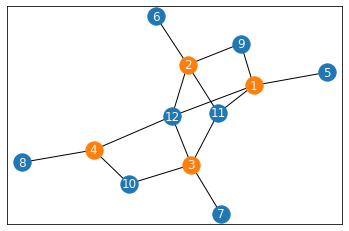

In [14]:
# Let us construct the graph for $n = 4$
(nverts, edge_list, vert_labels) = make_bad_example_for_greedy(4)
print(nverts)
print(edge_list)
print(vert_labels)

opt_cover = [1, 2, 3, 4]
plot_graph_with_vc(nverts, edge_list, opt_cover)


Adding vertex: 12 of degree 4 to the cover
Adding vertex: 11 of degree 3 to the cover
Adding vertex: 10 of degree 2 to the cover
Adding vertex: 9 of degree 2 to the cover
Adding vertex: 8 of degree 1 to the cover
Adding vertex: 7 of degree 1 to the cover
Adding vertex: 6 of degree 1 to the cover
Adding vertex: 5 of degree 1 to the cover
All edges removed
Greedy Cover Size:  8


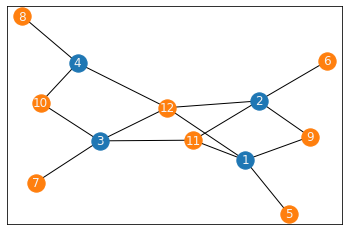

In [15]:
greedy_cover = greedy_vertex_cover(nverts, edge_list)
print('Greedy Cover Size: ', len(greedy_cover))
plot_graph_with_vc(nverts, edge_list, greedy_cover)

15
[(1, 6), (2, 7), (3, 8), (4, 9), (5, 10), (1, 11), (2, 11), (3, 12), (4, 12), (1, 13), (2, 13), (3, 13), (1, 14), (2, 14), (3, 14), (4, 14), (1, 15), (2, 15), (3, 15), (4, 15), (5, 15)]
['a_1', 'a_2', 'a_3', 'a_4', 'a_5', 'b_1^1', 'b_1^2', 'b_1^3', 'b_1^4', 'b_1^5', 'b_2^1', 'b_2^2', 'b_3^1', 'b_4^1', 'b_5^1']


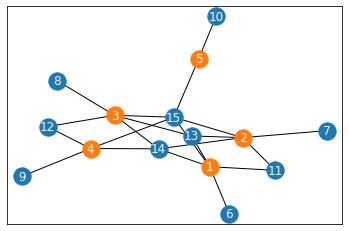

In [16]:
# Let us construct the graph for $n = 5$
n = 5
(nverts, edge_list, vert_labels) = make_bad_example_for_greedy(n)
print(nverts)
print(edge_list)
print(vert_labels)

opt_cover =list(range(1, n+1))

plot_graph_with_vc(nverts, edge_list, opt_cover)


Adding vertex: 15 of degree 5 to the cover
Adding vertex: 14 of degree 4 to the cover
Adding vertex: 13 of degree 3 to the cover
Adding vertex: 12 of degree 2 to the cover
Adding vertex: 11 of degree 2 to the cover
Adding vertex: 10 of degree 1 to the cover
Adding vertex: 9 of degree 1 to the cover
Adding vertex: 8 of degree 1 to the cover
Adding vertex: 7 of degree 1 to the cover
Adding vertex: 6 of degree 1 to the cover
All edges removed
Greedy Cover Size:  10


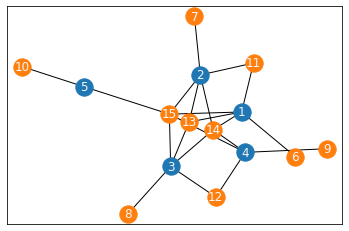

In [17]:
greedy_cover = greedy_vertex_cover(nverts, edge_list)
print('Greedy Cover Size: ', len(greedy_cover))
plot_graph_with_vc(nverts, edge_list, greedy_cover)

20
[(1, 7), (2, 8), (3, 9), (4, 10), (5, 11), (6, 12), (1, 13), (2, 13), (3, 14), (4, 14), (5, 15), (6, 15), (1, 16), (2, 16), (3, 16), (4, 17), (5, 17), (6, 17), (1, 18), (2, 18), (3, 18), (4, 18), (1, 19), (2, 19), (3, 19), (4, 19), (5, 19), (1, 20), (2, 20), (3, 20), (4, 20), (5, 20), (6, 20)]
['a_1', 'a_2', 'a_3', 'a_4', 'a_5', 'a_6', 'b_1^1', 'b_1^2', 'b_1^3', 'b_1^4', 'b_1^5', 'b_1^6', 'b_2^1', 'b_2^2', 'b_2^3', 'b_3^1', 'b_3^2', 'b_4^1', 'b_5^1', 'b_6^1']


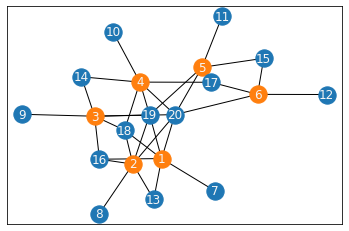

In [18]:
n = 6
(nverts, edge_list, vert_labels) = make_bad_example_for_greedy(n)
print(nverts)
print(edge_list)
print(vert_labels)

opt_cover =list(range(1, n+1))

plot_graph_with_vc(nverts, edge_list, opt_cover)

Adding vertex: 20 of degree 6 to the cover
Adding vertex: 19 of degree 5 to the cover
Adding vertex: 18 of degree 4 to the cover
Adding vertex: 17 of degree 3 to the cover
Adding vertex: 16 of degree 3 to the cover
Adding vertex: 15 of degree 2 to the cover
Adding vertex: 14 of degree 2 to the cover
Adding vertex: 13 of degree 2 to the cover
Adding vertex: 12 of degree 1 to the cover
Adding vertex: 11 of degree 1 to the cover
Adding vertex: 10 of degree 1 to the cover
Adding vertex: 9 of degree 1 to the cover
Adding vertex: 8 of degree 1 to the cover
Adding vertex: 7 of degree 1 to the cover
All edges removed
Greedy Cover Size:  14


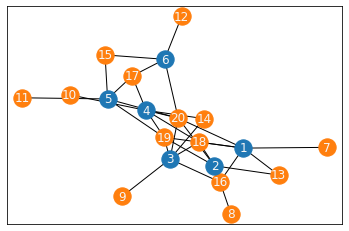

In [19]:
greedy_cover = greedy_vertex_cover(nverts, edge_list)
print('Greedy Cover Size: ', len(greedy_cover))
plot_graph_with_vc(nverts, edge_list, greedy_cover)

### Approximation Ratio for the Greedy Algorithm

In fact, we can prove that the greedy algorithm above produces a vertex cover which is no larger than $2 \log_2(n)$ times the optimal cover. Let $N_g$ be the size of the vertex cover found by a run of the greedy algorithm on a graph $G$ with $n$ nodes and $OPT$ be the size of the optimal (smallest) vertex cover. We have 

$$ \text{OPT} \leq N_g \leq 2 \log_2(n) \text{OPT} $$

We will now prove this fact by carefully running over the greedy algorithm.

Let us first fix some notation: 

The greedy algorithm starts with the given graph $G$ and at each iteration it removes the edges incident on the maximum degree vertex. 

Therefore, it goes through a sequence of graphs, each of which is a _subgraph_ of the input graph $G$:
$$ G_1, G_2, \ldots, G_k $$
where $G_{k}$ is a graph with no edges left and therefore represents the termination of the greedy algorithm.
Let $G_0= G$ denote the original graph. 

Let $v_i$ be the vertex with maximum degree in graph $G_i$ and $d_i$ be the degree of the vertex $v_i$. Specifically, $G_{i+1}$ results from the removal of the vertex $v_i$ in graph $G_i$ for $0 \leq i \leq k-1$.
Let  $|G_i|$ denote the number of edges in the graph $G_i$. 

The greedy algorithm finds a vertex cover $C_g:\ \{ v_0, \ldots, v_{k-1} \}$ of size $k = N_g$. Let OPT be the size of the optimal vertex cover and assume that $\text{OPT} < N_g$ (or else the required result trivially holds).

Let $C^*: \{ u_1, \ldots, u_{OPT} \}$ represent the optimal vertex cover. It may have nodes in common with $C_g$.

__Fact # 1:__ $C^*$ is a vertex cover for each graph $G_i$.

To see why, we note that for every edge in the graph $G$ at least one of its end points must lie in $C^*$. Therefore, since $G_i$ is a subgraph of $G$, its edges are but a subset of those of $G$ and hence $C^*$ is a cover of $G_i$.


__Fact # 2:__ $d_i \geq \frac{1}{\text{OPT}} |G_i|$.

$d_i$ is the maximum degree of any vertex in $G_i$.  There are a set of OPT nodes in $C^*$ that form a vertex cover of $G_i$. The sum of the degrees of these nodes in $C^*$ must equal $|G_i|$ (since every edge must be accounted for). The average degree of any node in the vertex cover $C^*$ is $\frac{1}{\text{OPT}} |G_i|$. The maximum degree must be at least this average. Thus the inequality follows.

Setting $i = OPT$, we note that 

$$\begin{array}{rll}
d_{OPT} & \geq \frac{1}{\text{OPT}} |G_{OPT}| \\  
& \geq \frac{1}{\text{OPT}} (|G| - d_0 - d_1 - \cdots -d_{OPT-1}) & \leftarrow\ \text{Since, each}\ G_i \ \text{obtained by successively removing}\ d_0, \ldots, d_{i-1}\ \text{edges from}\ G.
\end{array}$$

Rearranging, we have 
$$ OPT \times d_{OPT} + ( d_0 + \cdots +  d_{OPT-1} ) \geq |G| \,.$$

On the other hand, $d_0 \geq d_1 \geq \cdots \geq d_{OPT}$ since the maximum degrees in successive graphs cannot increase.

Therefore, 

$$ OPT \times d_{OPT} \leq (d_0 + \cdots + d_{OPT -1})\,.$$

Combining, we have

$$ 2 (d_0 + \cdots + d_{OPT -1}) \geq OPT \times d_{OPT} + ( d_0 + \cdots +  d_{OPT-1} ) \geq |G|\,,$$
or alternatively,
$$ d_0 + \cdots + d_{OPT-1} \geq \frac{|G|}{2}$$

The left hand side of the above inequality is simply the number of edges removed from the graph in the first OPT iterations of the greedy algorithm. The right hand side is half the number of edges in the original graph.

<div class="alert alert-block alert-info">
If OPT is the size of the optimal vertex cover, then the greedy algorithm gets rid of at least half the edges in the original graph in the first OPT iterations.
</div>

Thus, in $2\times \text{OPT}$ iterations, we will are left with at most one fourth of the edges, and in $k \times\text{OPT}$ iterations the greedy algorithm will have $\frac{1}{2^k}$ fraction of the original edges in the worst case.

This implies that in at most $OPT \log_2(n^2) = 2 OPT \log_2(n)$, all the edges in the original graph will be removed by the greedy algorithm. Therefore, we have the size of the greedy vertex cover satisfies

$$N_g \leq 2 \ \text{OPT}\ \log_2(n)\,.$$


## Greedy Algorithm Based on  Matching

Let us consider a different greedy approach to finding a vertex cover.

<div class="alert alert-block alert-info">
    <b> Maximal Matching Algorithm for Vertex Cover: </b>
<br> 1. While there are edges left in the graph:
<br> &nbsp; &nbsp;&nbsp;&nbsp;&nbsp;    1.1 Choose an edge $(i,j)$.
<br> &nbsp; &nbsp;&nbsp;&nbsp;&nbsp;     1.2 Add nodes $i$ and $j$ to the vertex cover 
<br> &nbsp; &nbsp;&nbsp;&nbsp;&nbsp;     1.3 Delete all incident edges on nodes $i$ and $j$.
<br>
</div>

Here the idea is to choose an edge in some arbitrary order, add _both_ the end points of the chosen edge to our cover and delete all edges incident on the two vertices that were just added to the cover.

Let's code this up and run through examples.

In [20]:
def matching_based_vertex_cover(n, edge_list):
    vertex_cover = [] 
    remaining_edges = list(edge_list)
    while len(remaining_edges) > 0:
        (i,j) = remaining_edges[0]
        vertex_cover.append(i)
        vertex_cover.append(j)
        remaining_edges = [(l,m) for (l,m) in remaining_edges if l != i and l != j and m != i and m != j]
        print(f'adding nodes {i}, {j} to the cover')
    return vertex_cover

adding nodes 1, 4 to the cover
adding nodes 2, 5 to the cover


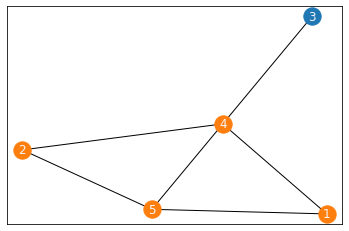

In [21]:
edge_list=[ (1,4), (1,5), (2,5), (2,4), (3,4), (4,5)]
vcover = matching_based_vertex_cover(5, edge_list)
plot_graph_with_vc(5, edge_list, vcover)

adding nodes 1, 4 to the cover
adding nodes 2, 5 to the cover
adding nodes 7, 8 to the cover


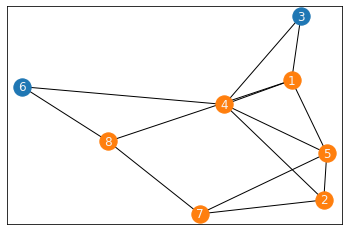

In [22]:
edge_list=[ (1,4), (1,5), (2,5), (2,4), (3,4), (4,5),(1,8),(2,7), (7,8),(4,6), (5,7), (6,8), (3,1)]
vcover = matching_based_vertex_cover(8, edge_list)
plot_graph_with_vc(8, edge_list, vcover)

Note that in each case, the matching based algorithm yields a vertex cover that is larger than the optimal cover and seems to perform worse than the greedy algorithm based on choosing maximum degree vertices. Nevertheless, the matching based algorithm provides a much better guarantee than the previous greedy algorithm.

Let $N_m$ be the size of the cover found by the matching based vertex cover algorithm and OPT be the size of the smallest cover. We have 

$$ \text{OPT} \leq N_m \leq 2 \times \text{OPT}$$

In other words, we have an approximation ratio of at most $2$. Why? 

The proof is very simple. Notice that each time the greedy algorithm chooses an as yet uncovered edge $(i,j)$ and adds both its end points, note that the optimal vertex cover _must_ have included at least _one_ of the end points. Thus, in the worst case, for every two nodes added by our matching algorithm, the optimal cover needs to include one of those two nodes. Thus, the result follows immediately.

In fact, for the examples we constructed to show the worst case performance for our greedy algorithm, we noted that the optimal cover was of size $n$ while the greedy algorithm gives a cover of size $\Omega(n \log(n))$. The matching based algorithm will find a cover of size $2n$ for each such instance.

We will have an opportunity to study the performance of the greedy algorithm using maximum degree against the mathching based algorithm over some randomly generated graphs in our upcoming problem set.

### That's all folks